# Praca domowa 2
## Wstęp do uczenia maszynowego
### Paweł Morgen

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import category_encoders as cat_enc
data = pd.read_csv("allegro-api-transactions.csv")
# data.head()

## 1. Kodowanie zmiennych kategorycznych

In [2]:
print('Ilość kategorii zmiennej it_location:', data.loc[:,'it_location'].unique().shape[0])
te=cat_enc.target_encoder.TargetEncoder(data)

encoded=te.fit_transform(data.loc[:,'it_location'],data.loc[:,'price'])
data['it_location_target_encoded'] = encoded

Ilość kategorii zmiennej it_location: 10056


#### Zalety target encodingu w stosunku do One-hot encodingu:
 * Efektywniejsza gospodarka pamięcią (tu mamy ponad 10000 unikatowych wartości; do OHC potrzebowalibyśmy 2^10000 bitów pamięci
 * Niosą pewną informację o związku między zmienną zakodowaną a zmienną celu - zwiększona skuteczność modelu
 
### Zakodowanie zmiennej *main_category*
Oprócz One-Hot użyjemy metody *leave one out* (`LeaveOneOutEncoder`) oraz metody Jamesa-Steina (`JamesSteinEncoder`). 

Adnotacja: próbowałem użyć haszowania (`HashingEncoder`), ale bez sukcesu (wyglądało to, jakby program wpadał w nieskończoną pętlę).


In [3]:
print('Ilość kategorii zmiennej main_category:', data.loc[:,'main_category'].unique().shape[0])

from category_encoders import LeaveOneOutEncoder, JamesSteinEncoder
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(data.loc[:,'main_category'].to_numpy().reshape(-1,1))


james_stein_encoder = JamesSteinEncoder()
james_stein_encoded = james_stein_encoder.fit_transform(data.loc[:,'main_category'],
                                                   data.loc[:,'price'])

leave_1_encoder = LeaveOneOutEncoder(data)
leave_1_encoded = leave_1_encoder.fit_transform(data.loc[:,'main_category'],
                                               data.loc[:,'price'])

data['main_one_hot_encoded'] = one_hot_encoded
data['main_leave_1_encoded'] = leave_1_encoded
data['main_js_encoded'] = james_stein_encoded

data.loc[:,['main_category','main_one_hot_encoded','main_leave_1_encoded','main_js_encoded']].head()

Ilość kategorii zmiennej main_category: 27


,main_category,main_one_hot_encoded,main_leave_1_encoded,main_js_encoded
0,Komputery,"(0, 12)\t1.0\n (1, 18)\t1.0\n (2, 6)\t1.0\...",121.814331,101.735793
1,"Odzież, Obuwie, Dodatki","(0, 12)\t1.0\n (1, 18)\t1.0\n (2, 6)\t1.0\...",75.859357,75.894257
2,Dom i Ogród,"(0, 12)\t1.0\n (1, 18)\t1.0\n (2, 6)\t1.0\...",72.434342,73.179117
3,Książki i Komiksy,"(0, 12)\t1.0\n (1, 18)\t1.0\n (2, 6)\t1.0\...",25.028061,25.346202
4,"Odzież, Obuwie, Dodatki","(0, 12)\t1.0\n (1, 18)\t1.0\n (2, 6)\t1.0\...",75.859080,75.894257


## 2. Uzupełnianie braków

In [15]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from math import sqrt

# Z powodów wydajności będziemy korzystać z 1/50 rekordów. 
# Testy przeprowadzimy dla zmiennych oryginalnych i ustandaryzowanych.
# Ponadto porównamy wyniki KNNImputera z SimpleImputerem, korzystającym z mediany.

original_data_num = data.loc[np.random.randint(0, data.shape[0], data.shape[0] // 50),
                    ['price', 'it_seller_rating', 'it_quantity']].reset_index(drop = True)

scaler = preprocessing.StandardScaler()
scaled_data_num = pd.DataFrame(scaler.fit_transform(original_data_num))
scaled_data_num.columns = original_data_num.columns
def run_tests(original_data_num):
    errors = [[None] * 10 for i in range(4)]
    imp = KNNImputer(n_neighbors = 2)
    simple_imp = SimpleImputer(strategy = 'median')
    for i in range(10):
        missing_data_num = original_data_num.copy()
        NA_indexes = np.random.randint(0, original_data_num.shape[0], original_data_num.shape[0] // 10)
        missing_data_num.loc[NA_indexes, 'it_seller_rating'] = np.nan
        knn_data_num = missing_data_num.copy()
        knn_data_num = pd.DataFrame(imp.fit_transform(knn_data_num))
        knn_data_num.columns = original_data_num.columns
        errors[0][i] = sqrt(mean_squared_error(original_data_num.loc[NA_indexes, 'it_seller_rating'], 
                       knn_data_num.loc[NA_indexes, 'it_seller_rating']))

        median_data_num = missing_data_num
        median_data_num.loc[:,'it_seller_rating'] = simple_imp.fit_transform(median_data_num.loc[:,'it_seller_rating'].to_numpy().reshape(-1,1))
        errors[1][i] = sqrt(mean_squared_error(original_data_num.loc[NA_indexes, 'it_seller_rating'], 
                       median_data_num.loc[NA_indexes, 'it_seller_rating']))
    for i in range(10):
        missing_data_num = original_data_num.copy()
        NA_indexes = [np.random.randint(0, original_data_num.shape[0], original_data_num.shape[0] // 10),
                          np.random.randint(0, original_data_num.shape[0], original_data_num.shape[0] // 10)]
        missing_data_num.loc[NA_indexes[0], 'it_seller_rating'] = np.nan
        missing_data_num.loc[NA_indexes[1], 'it_quantity'] = np.nan
        knn_data_num = missing_data_num.copy()
        knn_data_num = pd.DataFrame(imp.fit_transform(knn_data_num))
        knn_data_num.columns = original_data_num.columns
        errors[2][i] = sqrt(mean_squared_error(original_data_num.loc[NA_indexes[0], 'it_seller_rating'], 
                                               knn_data_num.loc[NA_indexes[0], 'it_seller_rating'])) + sqrt(
            mean_squared_error(original_data_num.loc[NA_indexes[1], 'it_quantity'],
                               knn_data_num.loc[NA_indexes[1], 'it_quantity']))
        median_data_num = missing_data_num
        median_data_num.loc[:,'it_seller_rating'] = simple_imp.fit_transform(median_data_num.loc[:,'it_seller_rating'].to_numpy().reshape(-1,1))
        median_data_num.loc[:,'it_quantity'] = simple_imp.fit_transform(median_data_num.loc[:,'it_quantity'].to_numpy().reshape(-1,1))
        # print(median_data_num)
        errors[3][i] = sqrt(mean_squared_error(original_data_num.loc[NA_indexes[0], 'it_seller_rating'], 
                                               median_data_num.loc[NA_indexes[0], 'it_seller_rating']))  + sqrt(
            mean_squared_error(original_data_num.loc[NA_indexes[1], 'it_quantity'],
                               median_data_num.loc[NA_indexes[1], 'it_quantity']))
    return errors
errors = run_tests(original_data_num)
errors_stand = run_tests(scaled_data_num)


In [18]:
def plot_summary(errors):
    error_df = pd.DataFrame({'knn1_column' : errors[0],
                             'median1_column' : errors[1],
                            'knn2_column' : errors[2],
                            'median2_column' : errors[3]})
    df = pd.melt(error_df,
           value_vars = ['knn1_column', 'median1_column', 'knn2_column', 'median2_column'],
           value_name = 'RSME_value')
    df = df.assign(n_with_NAs = df.loc[:, 'variable'].str.extract('([12]_column)'),
                                            imp_type = df.loc[:,'variable'].str.replace('([12]_column)', ''))

    sns.boxplot(x = df.loc[:,'n_with_NAs'],
                y = df.loc[:,'RSME_value'],
                hue = df.loc[:,'imp_type']).set_title('Imputation comparison')
    
data.loc[:,['it_quantity', 'it_seller_rating']].describe()

,it_quantity,it_seller_rating
count,420020.000000,420020.000000
mean,6748.274823,20402.593496
std,23387.248064,36682.898636
min,0.000000,-1.000000
25%,6.000000,1581.000000
50%,95.000000,6711.000000
75%,931.000000,21007.000000
max,99999.000000,292074.000000


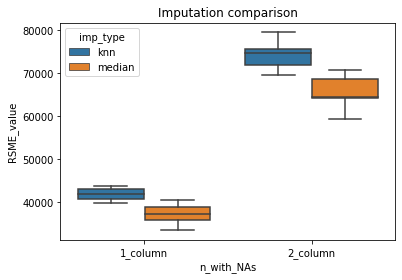

In [19]:
plot_summary(errors)

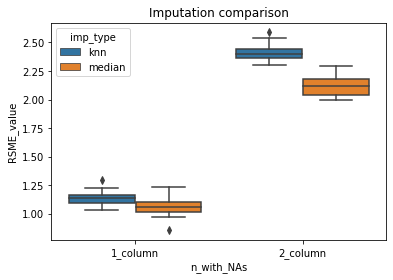

In [20]:
plot_summary(errors_stand)

## Wnioski
Wnioski są zaskakujące, bowiem metoda *KNN* daje dla tych danych gorsze efekty (większy błąd) niż zwykłe zastąpienie medianą. Można to wytłumaczyć sporą skośnością rozkładu danych w obu kolumnach (co widać po różnicy między średnią a medianą, zwłaszcza w kolumnie *it_quantity*. Tym niemniej obserwujemy, że dla większej ilości brakujących danych suma błędów jest również większa. Dla ustandaryzowanych zmiennych wręcz obserwujemy zależność liniową między błędem a ilością brakujących zmiennych; względny rozrzut błędów przy imputacji jest również mniejszy.